In [1]:
import sacrebleu
import numpy as np
import os
import math
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt 
import cv2
import pytube
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import json
import collections
import random
import re
import time
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

filename='videodatainfo_2017.json'
opened= open(filename, 'r')
trainData=json.load(opened)
opened.close()

In [4]:
videos=trainData["videos"]
captions=trainData["sentences"]
newCap={}
for sent in captions:
    newCap[sent["video_id"]]=[]
for sent in captions:
    newCap[sent["video_id"]].append(sent["caption"])
captions=newCap

In [5]:
#vCaptions={}
vCaptions=[] #list of valid captions
vFeatures=[] #list of valid video features npy files 
for root, dirs, files in os.walk("features"):
    for filename in files:
        filename=filename.split(".")
        captions_size = len(captions[filename[0]])
        
        vCaptions.extend(captions[filename[0]])
        vFeatures.extend(['features/'+filename[0]]*captions_size)


print(vCaptions[0])


a female voice over discusses japan


In [6]:
def add_tokens(val):
    return f"<start> {val} <end>"

vCaptions = map(add_tokens, vCaptions)
vCaptions = list(vCaptions)


In [7]:
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(vCaptions)
train_seqs = tokenizer.texts_to_sequences(vCaptions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(vCaptions) #train_seqs has the tokenized captions 

In [8]:
print(len(train_seqs))
print(len(vFeatures)) ##vFeatures and their corressponding tokenised captions in train_seqs
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


135680
135680


In [9]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

In [26]:
video_to_cap_vector = collections.defaultdict(list)
for vid, cap in zip(vFeatures, cap_vector):
  video_to_cap_vector[vid].append(cap)

# Create training and validation sets using an 80-20 split randomly.
vid_keys = list(video_to_cap_vector.keys())
random.seed(0)
random.shuffle(vid_keys)

slice_index = int(len(vid_keys)*0.7)
vid_name_train_keys, vid_name_val_keys = vid_keys[:slice_index], vid_keys[slice_index:]

vid_name_train = []
cap_train = []
for vidt in vid_name_train_keys:
  capt_len = len(video_to_cap_vector[vidt])
  vid_name_train.extend([vidt] * capt_len)
  cap_train.extend(video_to_cap_vector[vidt])

vid_name_val = []
cap_val = []
for vidv in vid_name_val_keys:
  capv_len = len(video_to_cap_vector[vidv])
  vid_name_val.extend([vidv] * capv_len)
  cap_val.extend(video_to_cap_vector[vidv])

In [41]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 256
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(vid_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
encoding_dim = 128
attention_features_shape = 80

In [42]:
num_steps

370

In [43]:
def map_func(vid_name, cap):
  vid_tensor = np.load(vid_name.decode('utf-8')+'.npy')
  return vid_tensor, cap

In [44]:
dataset = tf.data.Dataset.from_tensor_slices((vid_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [45]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [46]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    w1 = self.W1(features)
    w2 = self.W2(hidden_with_time_axis)
    attention_hidden_layer = (tf.nn.tanh(w1 + w2))
    score = self.V(attention_hidden_layer)
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [47]:
class RNN_Encoder(tf.keras.Model):
    def __init__(self, encoding_dim):
        super(RNN_Encoder, self).__init__()
        self.lstm1 = tf.keras.layers.LSTM(encoding_dim,
                                          return_sequences=True
                                          )
        self.lstm2 = tf.keras.layers.LSTM(encoding_dim,
                                          return_sequences=True
                                          )
        
    def call(self, x, training=True):
        output1 =  self.lstm1(x,training=training)
        output2 = self.lstm2(output1,training=training)
        return output1, output2

In [50]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.units,
                                        return_sequences=True,
                                        return_state=True)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector,1), x], axis=-1)
        output, state, _ = self.lstm(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [51]:
encoder = RNN_Encoder(encoding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [52]:
checkpoint_path = "./checkpoints_meh/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [53]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [54]:
print(start_epoch)
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []


0


['_CHECKPOINTABLE_OBJECT_GRAPH',
 'decoder/attention/V/bias/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/bias/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/bias/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/kernel/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/V/kernel/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/bias/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/bias/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/bias/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/kernel/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/kernel/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W1/kernel/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
 'decoder/attention/W2/bias/.ATTRIBUTES/VARIABLE_VALU

In [55]:
@tf.function
def train_step(vid_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  out_list = []
  with tf.GradientTape() as tape:

      out1, out2 = encoder(vid_tensor)
      features = tf.concat([out1, out2], 2)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [56]:
EPOCHS = 50

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (vid_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(vid_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.2915
Epoch 1 Batch 100 Loss 0.7078
Epoch 1 Batch 200 Loss 0.7006
Epoch 1 Batch 300 Loss 0.6253
Epoch 1 Loss 0.708527
Time taken for 1 epoch 440.0467493534088 sec

Epoch 2 Batch 0 Loss 0.6366
Epoch 2 Batch 100 Loss 0.5700
Epoch 2 Batch 200 Loss 0.5964
Epoch 2 Batch 300 Loss 0.5645
Epoch 2 Loss 0.581762
Time taken for 1 epoch 354.1756474971771 sec

Epoch 3 Batch 0 Loss 0.5436
Epoch 3 Batch 100 Loss 0.5282
Epoch 3 Batch 200 Loss 0.5634
Epoch 3 Batch 300 Loss 0.5227
Epoch 3 Loss 0.535426
Time taken for 1 epoch 340.23296761512756 sec

Epoch 4 Batch 0 Loss 0.5150
Epoch 4 Batch 100 Loss 0.5050
Epoch 4 Batch 200 Loss 0.5141
Epoch 4 Batch 300 Loss 0.4512
Epoch 4 Loss 0.507340
Time taken for 1 epoch 340.8348412513733 sec

Epoch 5 Batch 0 Loss 0.5221
Epoch 5 Batch 100 Loss 0.4683
Epoch 5 Batch 200 Loss 0.4845
Epoch 5 Batch 300 Loss 0.4649
Epoch 5 Loss 0.486849
Time taken for 1 epoch 341.2730703353882 sec

Epoch 6 Batch 0 Loss 0.5206
Epoch 6 Batch 100 Loss 0.4510
Epoch 6 Bat

In [66]:
EPOCHS = 100

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (vid_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(vid_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.1288
Epoch 1 Batch 100 Loss 0.1222
Epoch 1 Batch 200 Loss 0.1358
Epoch 1 Batch 300 Loss 0.1290
Epoch 1 Loss 0.128521
Time taken for 1 epoch 339.8004479408264 sec

Epoch 2 Batch 0 Loss 0.1327
Epoch 2 Batch 100 Loss 0.1227
Epoch 2 Batch 200 Loss 0.1305
Epoch 2 Batch 300 Loss 0.1293
Epoch 2 Loss 0.127817
Time taken for 1 epoch 352.0299656391144 sec

Epoch 3 Batch 0 Loss 0.1282
Epoch 3 Batch 100 Loss 0.1214
Epoch 3 Batch 200 Loss 0.1337
Epoch 3 Batch 300 Loss 0.1253
Epoch 3 Loss 0.127828
Time taken for 1 epoch 341.46807861328125 sec

Epoch 4 Batch 0 Loss 0.1332
Epoch 4 Batch 100 Loss 0.1206
Epoch 4 Batch 200 Loss 0.1291
Epoch 4 Batch 300 Loss 0.1221
Epoch 4 Loss 0.126247
Time taken for 1 epoch 338.1523551940918 sec

Epoch 5 Batch 0 Loss 0.1222
Epoch 5 Batch 100 Loss 0.1208
Epoch 5 Batch 200 Loss 0.1213
Epoch 5 Batch 300 Loss 0.1238
Epoch 5 Loss 0.125375
Time taken for 1 epoch 337.62411975860596 sec

Epoch 6 Batch 0 Loss 0.1218
Epoch 6 Batch 100 Loss 0.1211
Epoch 6 Ba

KeyboardInterrupt: 

In [58]:
ckpt_manager.save()


'./checkpoints_meh/train/ckpt-21'

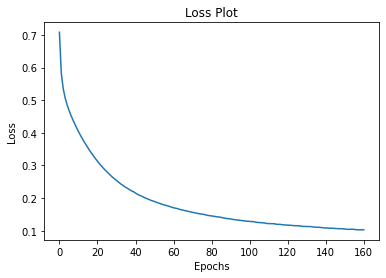

In [67]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [60]:
def validate(video, test=False):
    hidden = decoder.reset_state(batch_size=1)

    if not test:
        vid_tensor_val = np.load(video+'.npy')
    else:
        vid_tensor_val = video
    vid_tensor_val = tf. convert_to_tensor(vid_tensor_val)
    vid_tensor_val = tf.reshape(vid_tensor_val, (1, vid_tensor_val.shape[0], vid_tensor_val.shape[1]))

    out1, out2 = encoder(vid_tensor_val, training=False)
    features = tf.concat([out1, out2], 2)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden= decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [61]:
# captions on the validation set
actual, predicted = list(), list()

rid = np.random.randint(0, len(vid_name_val))
for video, cap  in zip(vid_name_val[:], cap_val[:]):
    real_caption = [tokenizer.index_word[i] for i in cap if i not in [0]]
    real_caption = real_caption[1:-1]
    #real_caption = ' '.join(real_caption)
    result = validate(video)
    if (result[-1] == '<end>'):
        result = result[:-1]
    #prediction_caption = ' '.join(result)
    actual.append(real_caption)
    predicted.append(result)

In [159]:
# captions on the validation set
actual, predicted = list(), list()

rid = np.random.randint(0, len(vid_name_val))
for video, cap  in zip(vid_name_val[:], cap_val[:]):
    real_caption = [tokenizer.index_word[i] for i in cap if i not in [0]]
    real_caption = real_caption[1:-1]
    result = validate(video)
    if (result[-1] == '<end>'):
        result = result[:-1]
    actual.append(real_caption)
    predicted.append(result)

In [160]:
ref = []
targ= []
for cap, pred in zip(actual, predicted):
    ref.append(' '.join(cap))
    targ.append(' '.join(pred))

In [161]:
print('BLEU: %f' % corpus_bleu(ref, targ, weights=(1.0, 0, 0, 0)))

BLEU: 0.268873


In [74]:
for cap, pred in zip(ref[:100], targ[:100]):
    print("True caption: ",cap)
    print("Predicted caption", pred)

True caption:  a guying giving santa a check
Predicted caption two men discuss how he test a guy near middle weather
True caption:  a man in a commercial talking to santa claus
Predicted caption a man discusses the united states his frame while giving a new clip from the united states
True caption:  a man is dressed as santa
Predicted caption 2 people shot of police automobile scenes
True caption:  a man is speaking to santa claus
Predicted caption man in a suit talks outside of a commercial
True caption:  a man is talking to santa claus
Predicted caption a person talks outside in front of a small set of building obama
True caption:  a man sings a laser bolt to another man
Predicted caption a man is talking to another person in front of a city
True caption:  a used car <unk> s <unk>
Predicted caption a clip of a clip from the background
True caption:  a woman talking about relationships
Predicted caption a clip taken from a movie
True caption:  an attorney commercial showing a lawyer g

In [156]:
rid = np.random.randint(0, len(vid_name_val))
video = vid_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]][1:-1])
result = validate(video)
if (result[-1] == '<end>'):
        result = result[:-1]
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))

Real Caption: a person is solving a rubik s cube
Prediction Caption: a person is showing here a rubik s cube


In [158]:
video

'features/video6625'